# Degrees of Change map

A climate anomaly is the difference of a future climate compared to the present climate. In climate change studies, temperature anomalies are more important than absolute temperature ([NOAA](https://www.ncdc.noaa.gov/monitoring-references/dyk/anomalies-vs-temperature)). A temperature anomaly is the difference from an average, or baseline, temperature. The baseline temperature is typically computed by averaging 30 or more years of temperature data. In this example we we will create maps that show maximum temperature anomaly between a baseline time period (1961-1990) and end of century (2070-2099) period using the following downscaled LOCA data:
- Annual averages of future projections from HadGEM2-ES model, RCP 4.5 scenario
- Annual averages of future projections from HadGEM2-ES model, RCP 8.5 scenario
- Annual averages of historical projections from HadGEM2-ES model

Import required python libraries. There are several python libraries for making maps. In this example we will use matplotlib basemap toolkit, which is a python library for plotting 2D data on maps.
> Basemap does not do any plotting on it’s own, but provides the facilities to transform coordinates to one of 25 different map projections (using the PROJ.4 C library). Matplotlib is then used to plot contours, images, vectors, lines or points in the transformed coordinates. Shoreline, river and political boundary datasets (from Generic Mapping Tools) are provided, along with methods for plotting them. The GEOS library is used internally to clip the coastline and polticial boundary features to the desired map projection region.

> [Matplotlib Basemap Toolkit](https://matplotlib.org/basemap/users/intro.html)

In [1]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import math
from textwrap import wrap
import gdal
import os
from glob import glob

### Define variables

To work with other models or climate variables (tasmax, tasmin, pr), modify the variable values in the cell below.

In [2]:
# Entry point of the Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Get current working directory, all outputs and temporary files will be save in this directory
# If you want to set a different directory you can do it here
data_dir = os.getcwd()
print(data_dir)

# Time periods
baselinePeriod = [1961, 1990]
futurePeriod = [2070, 2099]

/home/mukhtyar/projects/caladapt-docs/cookbook


### Define functions

In [7]:
# Get resource url on Cal-Adapt API for timeseries representing
# model, scenario, climate variable combintation
def getUrl(climvar, model, scenario):
    url = api + '/series/' + '_'.join([climvar, 'year', model, scenario]) + '/'
    if (scenario == 'historical'):
        url += str(baselinePeriod[0]) + '-01-01/' + str(baselinePeriod[1]) + '-12-31/'
    else:
        url += str(futurePeriod[0]) + '-01-01/' + str(futurePeriod[1]) + '-12-31/'
    return url

# Download geotiff file from url and write it out to a local directory
# Local directory is set in the previous cell
# Make sure you have write permission to this directory
def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(os.path.join(data_dir, local_filename), 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return local_filename

# Convert a locally stored geotiff file to a numpy array
# This geotiff file is first reprojected from original EPSG 4326 to Web Mercator - because once the raster
# is converted to numpy array it loses the coordinate information and you can run into misalighment issues 
# with other overlays while plotting the numpy arrays in Python mapping libraries
def convertImageToArray(rstore):
    # Get url to geotiff file on Cal-Adapt API
    url = rstore['image']
    # Download geotiff file and save it to directory
    filename = download_file(url)
    # Read the geotiff with gdal
    input_raster = gdal.Open(filename)
    # Set filename for rerpojected geotiff file
    reprojectedFilename = os.path.join(data_dir, 'reproject.tif')
    # Reproject geotiff file from EPSG 4326 to Web Mercator
    gdal.Warp(reprojectedFilename, input_raster, dstSRS='EPSG:3857')

    ds = gdal.Open(reprojectedFilename)
    band = ds.GetRasterBand(1)
    # Get nodata value from the GDAL band object
    nodata = band.GetNoDataValue()
    # Creates a numpy array that contains the original nodata values. 
    data = band.ReadAsArray()
    # Any calculations will be wrong if nodata values are not taken care of
    # Create a masked numpy array for making calculations without nodata values
    rasterArray = np.ma.masked_equal(data, nodata)
    band = None
    ds = None
    # Remove original geotiff and reprojected geotiff file
    os.remove(filename)
    os.remove(reprojectedFilename)
    return rasterArray

# From the raster series url retrieved by function getUrl(climvar, model, scenario)
# get list of raster stores for each year and convert raster store to numpy array.
# Returns a list of numpy arrays.
def getData(url):
    # Make request
    response = requests.get(url)
    array_list = []
    if response.ok:
        series = response.json()
        # Get a list of Raster Stores in Series
        rstores = series['results']
        for item in rstores:
            array_list.append(convertImageToArray(item))
        return array_list
    else:
        return None

### Get data for baseline time period and future projections



In [8]:
historical_modeled = getData(getUrl('tasmax', 'HadGEM2-ES', 'historical'))
rcp45_modeled = getData(getUrl('tasmax', 'HadGEM2-ES', 'rcp45'))
rcp85_modeled = getData(getUrl('tasmax', 'HadGEM2-ES', 'rcp85'))
print(rcp45_modeled) 

[masked_array(data =
 [[-- -- -- ..., 287.5157165527344 286.964599609375 289.38958740234375]
 [-- -- -- ..., 288.24774169921875 289.57391357421875 290.4110107421875]
 [-- -- -- ..., 288.3319396972656 290.4870910644531 290.8188781738281]
 ..., 
 [-- -- -- ..., 304.6241149902344 303.48480224609375 305.2071838378906]
 [-- -- -- ..., 304.5249938964844 304.5370178222656 305.3215637207031]
 [-- -- -- ..., 304.3125915527344 304.5145568847656 305.0677795410156]],
             mask =
 [[ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = 1e+30)
, masked_array(data =
 [[-- -- -- ..., 288.5013732910156 287.9804382324219 290.4064025878906]
 [-- -- -- ..., 289.2367248535156 290.586181640625 291.44354248046875]
 [-- -- -- ..., 289.3406677246094 291.510009765625 291

### Calculate baseline average (1961-1990) using modeled historical

In [12]:
# Create a new array by averaging list of arrays
# You can convert degrees Kelvin to Celsius by adding -273. 
# Since this does not affect the final Degrees of Change values I'm skipping this step
historical_modeled_avg = np.ma.array(tuple(historical_modeled)).mean(axis=0)
print(historical_modeled_avg.min(), historical_modeled_avg.max())

# If you want the Degrees of Change map in Fahrenheit, you should first 
# convert degrees Kelvin to Fahrenheit at this step, e.g.:
#historical_modeled_avg_F = (historical_modeled_avg - 273.15) * 1.8000 + 32.00
#print(historical_modeled_avg_F.min(), historical_modeled_avg_F.max())

276.554785156 305.222363281


### Calculate future average (2070-2099) using modeled projections for RCP4.5 and RCP8.5

In [13]:
# Create a new array by averaging list of arrays
# You can convert degrees Kelvin to Celsius by adding -273. 
# Since this does not affect the final Degrees of Change values I'm skipping this step
rcp45_modeled_avg = np.ma.array(tuple(rcp45_modeled)).mean(axis=0)
print(rcp45_modeled_avg.min(), rcp45_modeled_avg.max())

# If you want the Degrees of Change map in Fahrenheit, you should first 
# convert degrees Kelvin to Fahrenheit at this step, e.g.:
#rcp45_modeled_avg_F = (rcp45_modeled_avg - 273.15) * 1.8000 + 32.00
#print(rcp45_modeled_avg_F.min(), rcp45_modeled_avg_F.max())

280.633984375 309.174658203


In [14]:
# Create a new array by averaging list of arrays
# You can convert degrees Kelvin to Celsius by adding -273. 
# Since this does not affect the final Degrees of Change values I'm skipping this step
rcp85_modeled_avg = np.ma.array(tuple(rcp85_modeled)).mean(axis=0)
print(rcp85_modeled_avg.min(), rcp85_modeled_avg.max())

# If you want the Degrees of Change map in Fahrenheit, you should first 
# convert degrees Kelvin to Fahrenheit at this step, e.g.:
#rcp85_modeled_avg_F = (rcp85_modeled_avg - 273.15) * 1.8000 + 32.00
#print(rcp85_modeled_avg_F.min(), rcp85_modeled_avg_F.max())

282.520556641 310.934179687


### Calculate degrees of change

In [15]:
rcp45 = rcp45_modeled_avg - historical_modeled_avg
rcp45.min(), rcp45.max()

# If you want the Degrees of Change data in Fahrenheit, uncomment the following lines
#rcp45_F = rcp45_modeled_avg_F - historical_modeled_avg_F
#rcp45_F.min(), rcp45_F.max()

(2.0123046875000341, 5.2956787109374659)

In [16]:
rcp85 = rcp85_modeled_avg - historical_modeled_avg
rcp85.min(), rcp85.max()

# If you want the Degrees of Change data in Fahrenheit, uncomment the following lines
#rcp85_F = rcp85_modeled_avg_F - historical_modeled_avg_F
#rcp85_F.min(), rcp85_F.max()

(2.4934570312499886, 7.4258544921874545)

### Plot degrees of change maps

Create a list of values for binning the data

In [17]:
minVal = math.floor(rcp45.min()) # math.floor(rcp45_F.min())
maxVal = math.ceil(rcp85.max()) # math.floor(rcp85_F.max())
data_bins = list(range(minVal, maxVal + 1))
minVal, maxVal, data_bins

(2, 8, [2, 3, 4, 5, 6, 7, 8])

Get bounds of image. There are several ways to do this. For this exercise I opened one of the GeoTIFF files in QGIS and got the bounds from the metadata information.

In [18]:
(xmin, xmax, ymin, ymax) = (-124.5625, -113.375, 31.5625, 43.75)
print(xmin, xmax, ymin, ymax)

-124.5625 -113.375 31.5625 43.75


Define a function that takes two arguments - (1) axes to plot figure on, (2) data array and returns a map

In [19]:
# Projection used in Web Mercator
def setup_map(ax, data):
    m = Basemap(resolution = 'l', # change this value to h for creating high resolution map
              projection='merc', lat_0=0, 
              llcrnrlon = xmin, urcrnrlon = xmax,
              llcrnrlat = ymin, urcrnrlat = ymax,
              ax = ax
             )
    x = np.linspace(0, m.urcrnrx, data.shape[1])
    y = np.linspace(0, m.urcrnry, data.shape[0])

    xx, yy = np.meshgrid(x, y)
    cs = m.contourf(xx, yy, np.flipud(data), tuple(data_bins), cmap='YlOrRd')
    cbar = m.colorbar(cs ,location='bottom', pad="5%")
    cbar.set_label('Degree Celsius')
    
    # Draw other layers
    m.drawcounties()
    #m.readshapefile('data/cb_2016_us_county_500k', 'counties')
    return m

After you run the next cell, the map will be drawn below this cell. This might take a few seconds. If you have set the resolution of the map to high, it might take longer.

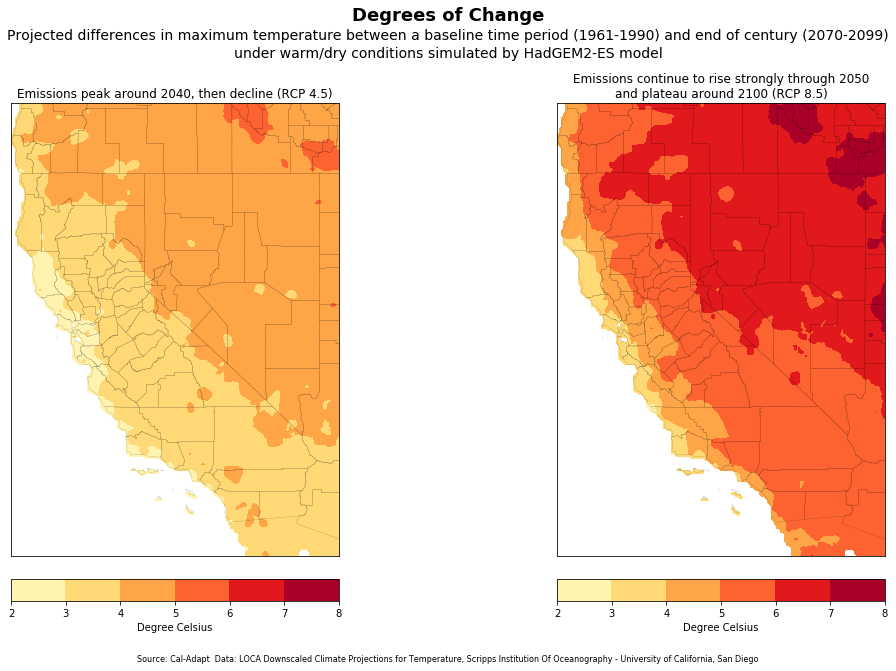

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].set_title('\n'.join(wrap('Emissions peak around 2040, then decline (RCP 4.5)', width=100)))
map1 = setup_map(ax[0], rcp45)

ax[1].set_title('\n'.join(wrap('Emissions continue to rise strongly through 2050 and plateau around 2100 (RCP 8.5)', width=50)))
map2 = setup_map(ax[1], rcp85)

plt.subplots_adjust(wspace=0, hspace=5)
plt.suptitle('Degrees of Change', fontsize=18, fontweight='bold', ha='center')
plt.tight_layout(pad=8, w_pad=0.5, h_pad=5)
desc_str1 = 'Projected differences in maximum temperature between a baseline time period (1961-1990) and end of century (2070-2099)'
desc_str2 = 'under warm/dry conditions simulated by HadGEM2-ES model';
plt.gcf().text(0.5, 0.935, desc_str1, fontsize=14, ha='center')
plt.gcf().text(0.5, 0.91, desc_str2, fontsize=14, ha='center')
attrib_str1 = 'Source: Cal-Adapt  Data: LOCA Downscaled Climate Projections for Temperature, Scripps Institution Of Oceanography - University of California, San Diego'
plt.gcf().text(0.5, 0.07, attrib_str1, fontsize=8, ha='center')
# Uncomment following line to save map as image
# plt.savefig('DegreesOfChange.png', dpi=300)
plt.show()

<center>The End<center>
![End](image/border.png)

### Extra - Export numpy array to GeoTIFF file

If you want to export any of the numpy arrays you calculated to a GeoTIFF file, you can modify the following code for your needs.

#### 1. Get information about projection, spatial extent from one of the GeoTIFF files

In [28]:
# Download image file
url = 'http://api.cal-adapt.org/media/img/tasmax_year_HadGEM2-ES_rcp45_r1i1p1_2006.LOCA_2016-04-02.16th.CA_NV.tif'
filename = download_file(url)

# Open file with gdal
ds = gdal.Open(filename)
band = ds.GetRasterBand(1)

# Geotransform and projection
gt = ds.GetGeoTransform()   
proj = ds.GetProjection()

# X, Y resolution
xres = gt[1]
yres = gt[5]

# Number of rows and columns
rows = ds.RasterXSize
cols = ds.RasterYSize

# Calculate bounds using geotransform, resolution, num. of rows and columns
xmin = gt[0] + xres
xmax = gt[0] + (xres * rows) - xres
ymin = gt[3] + (yres * cols) + yres
ymax = gt[3] - yres

os.remove(filename)
band = None
ds = None

print(proj)
print(gt)
print(xmin, xmax, ymin, ymax)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
(-124.5625, 0.0625, 0.0, 43.75, 0.0, -0.0625)
-124.5 -113.4375 31.5 43.8125


#### 2. Export raster

Work in progress!

In [27]:
outFileName = os.path.join(data_dir, 'rcp45_DOC.tif')

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(gt) # sets same geotransform as input
outdata.SetProjection(proj) # sets same projection as input
outdata.GetRasterBand(1).WriteArray(rcp45)
outdata.FlushCache() # saves to disk!!
outdata = None

ValueError: array larger than output file, or offset off edge